In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surmise.emulation import emulator
import dill as pickle
import emcee
from scipy import stats

import model
import priors

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
# Command-line arguments
epsilon = 0.1
ntrain = 200
fat_frac = 0.3

fat_id = f'fat_{fat_frac:.1f}'
emu_id = f'eps_{epsilon:.4e}_ntrain_{ntrain}' + '_' + fat_id

design_points = np.load('datfiles/' + fat_id + '_posterior_samples.npy')
input_points = np.load('datfiles/' + fat_id + '_posterior_chain.npy')

nrpar = 16
ntest = design_points.shape[0] - ntrain

f = design_points[:ntrain, :].T
w = input_points[:ntrain, :nrpar]

# Set up the surmise emulator.
args = {'epsilon' : epsilon, 'warnings' : True}
emu = emulator(x=model.x, theta=w, f=f, method='PCGPwM', args=args)

PCGPwM considering  48 PCs


In [3]:
# test points
fp = design_points[ntrain:, :]
wp = input_points[ntrain:, :nrpar]

In [4]:
fp.shape, wp.shape

((800, 573), (800, 16))

In [23]:
theta_star = np.load('datfiles/theta_star.npy')[:16]
y = model.calculate(theta_star)
dy = 0.01*np.abs(y)

In [24]:
def ln_prior(theta):
    return np.sum([p.logpdf(t) for (p, t) in zip(priors.priors, theta)])


def ln_likelihood(theta):
    p = emu.predict(theta=theta)
    mu = p.mean().T[0]
    var = dy**2 + p.var().T[0]
    return np.sum(-np.log(np.sqrt(2*np.pi*var)) + np.sum(-0.5*(y - mu)**2 / var))


def ln_posterior(theta):
    lnpi = ln_prior(theta)
    if lnpi == -np.inf:
        return -np.inf
    return lnpi + ln_likelihood(theta)


nd = theta_star.size
nw = 2*nd

p0 = np.array(
    [stats.norm(theta_star, 0.01*np.abs(theta_star)).rvs() for _ in range(nw)]
)

backend = emcee.backends.HDFBackend('emulators/backends/' + emu_id + '_rpar_only.h5')
backend.reset(nw, nd)
moves = [(emcee.moves.DEMove(), 0.2), (emcee.moves.DESnookerMove(), 0.8)]
sampler = emcee.EnsembleSampler(nw, nd, ln_posterior, moves=moves,
                                backend=backend)

In [25]:
state = sampler.run_mcmc(p0, 1000, thin_by=50, tune=True, progress=True)

100%|██████████| 50000/50000 [56:03<00:00, 14.86it/s]  


In [39]:
def ln_likelihood_brick(theta):
    mu = model.calculate(theta)
    return np.sum(-np.log(np.sqrt(2*np.pi)*dy) + np.sum(-0.5*((y - mu) / dy)**2))


def ln_posterior_brick(theta):
    lnpi = ln_prior(theta)
    if lnpi == -np.inf:
        return -np.inf
    return lnpi + ln_likelihood_brick(theta)


backend_brick = emcee.backends.HDFBackend('emulators/backends/' + emu_id + '_rpar_only_brick.h5')
backend_brick.reset(nw, nd)
moves = [(emcee.moves.DEMove(), 0.2), (emcee.moves.DESnookerMove(), 0.8)]

In [40]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [41]:
from multiprocessing import Pool

In [42]:
with Pool(processes=16) as pool:
    sampler_brick = emcee.EnsembleSampler(nw, nd, ln_posterior_brick, moves=moves,
                                backend=backend_brick, pool=pool)
    state = sampler_brick.run_mcmc(p0, 1000, thin_by=50, tune=True, progress=True)

 91%|█████████ | 45348/50000 [2:40:53<09:28,  8.19it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:
flat_chain = sampler.get_chain(discard=500, flat=True)
flat_chain_brick = sampler_brick.get_chain(discard=500, flat=True)

In [44]:
from corner import corner

In [45]:
# fig = corner(flat_chain)
# fig = corner(flat_chain_brick, fig=fig)

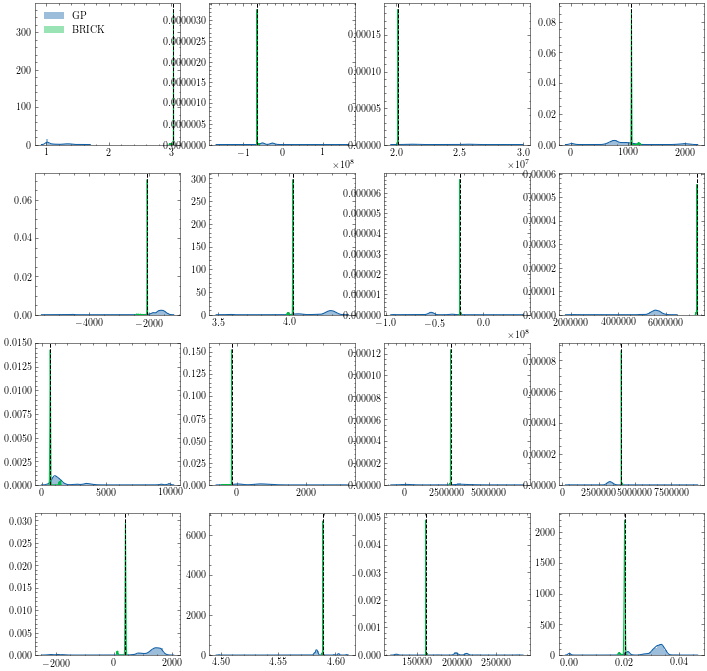

In [46]:
fig, ax = plt.subplots(4, 4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        sns.distplot(flat_chain[:, i*4+j], ax=ax[i, j], label='GP')
        sns.distplot(flat_chain_brick[:, i*4+j], ax=ax[i, j], label='BRICK')
        ax[i, j].axvline(theta_star[i*4+j], color='k', linestyle='--')
        
ax[0, 0].legend();

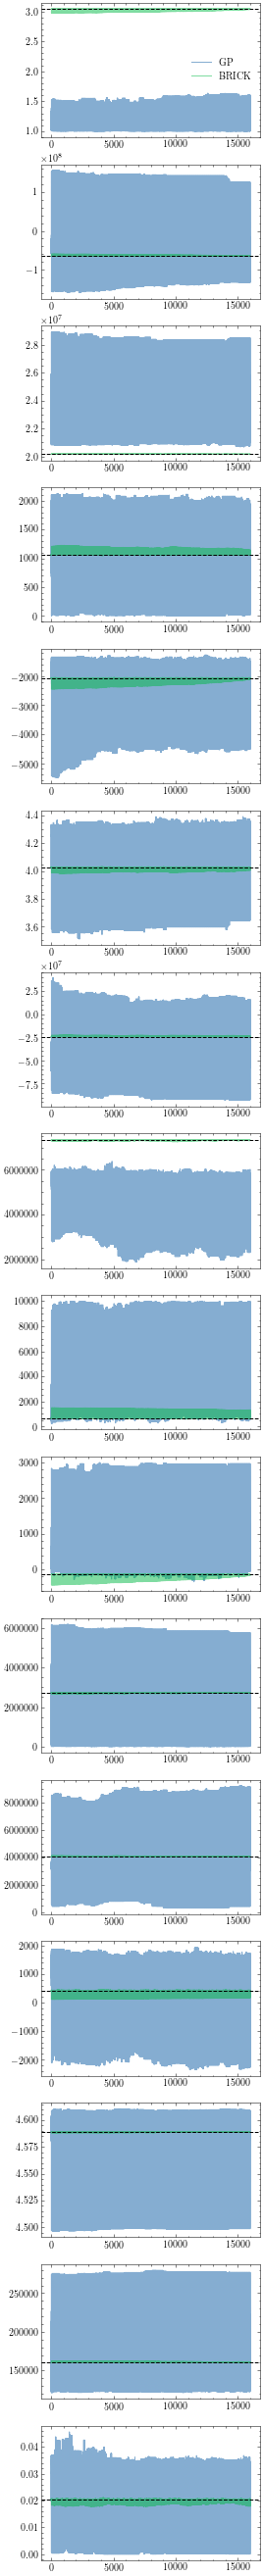

In [49]:
fig, ax = plt.subplots(16, figsize=(gr*h, 16*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = i*4+j
        ax[k].plot(flat_chain[:, k], label='GP', alpha=0.5)
        ax[k].plot(flat_chain_brick[:, i*4+j], label='BRICK', alpha=0.5)
        ax[k].axhline(theta_star[k], color='k', linestyle='--')
        
ax[0].legend();